# Mask  Type Classification
### Akanksha Panwar, Jatin Katyal & Rucha Shende
Th goal is to classify given images into four classes based on what mask type the subject in the image is wearing. The four classes are:
1. Cloth Mask (label 0)
2. FFP2 Mask (label 1)
3. No Mask (label 2)
4. Surgical Mask (label 3)

Importing required packages

In [1]:
# For data loading and processing
from torchvision.transforms import Compose,Resize,Normalize,ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math

#For model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#For shwing images and graphs
from matplotlib import pyplot as plt

#For evaluation
from sklearn.metrics import confusion_matrix

#For generic torch functions
import torch

declaring some constants variables

In [2]:
imagePath = 'Data/classified/'
mean=[0.485, 0.456, 0.406]
std=[0.225, 0.225, 0.225]
test_ratio = 0.2
validation_ratio = 0.2

## Data
The data used in the project is a combination of many sources.
1. [Kaggle FaceMask Dataset](https://www.kaggle.com/andrewmvd/face-mask-detection): The data set has 853 images images of people wearing different kinds of masks with one or more person in frame. We used the anotations provided with dataset which contains the bounding boxes for more than 4000 faces  from orignal 853 images. These bounding  boxes were used to crop and extract the images with face mask. Later all these extracted images were manually labeled as Cloth Mask, FFP2 Mask, No Mask & Surgical Mask. Some of images were very small in resolution so we dropped those from our task.

2. After carefully  selecting the images from above dataset we found a class imbalance in our dataset and we could use more images for the task. To supplement our dataset we searched  for images  related our task on [Google](https://www.google.ca) which lead to various websites.

Using ImageFolder and DataLoader for finding dataset andusing Compose to preprocess images using Resize & Normalize.

In [4]:
transformer = Compose([Resize((128,128)), ToTensor(), Normalize(mean=mean,std=std)])
data = ImageFolder(root=imagePath, transform=transformer)
loader = DataLoader(data,batch_size=32)

## Train validation test split
We reserved 20% data for testing and rest was again devided into 80% training & 20% validation.

In [5]:
# Defining Test Validation & Train sizes
test_size = math.floor(test_ratio*len(data))
train_size = len(data) - test_size
validation_size = math.floor(validation_ratio*train_size)
train_size -= validation_size
print('train_size:{}, validation_size:{}, test_size:{}, total:{}'.format(train_size,validation_size,test_size,
                                                                         train_size+validation_size+test_size))

train_size:849, validation_size:212, test_size:265, total:1326


In [6]:
# Loaders with split
torch.manual_seed(0)
shuffledIndices = torch.randperm(len(data))
train_loader = DataLoader(data,batch_size=32,sampler=shuffledIndices[:train_size])
validation_loader = DataLoader(data,batch_size=32,sampler=shuffledIndices[train_size:train_size+validation_size])
test_loader = DataLoader(data,batch_size=32,sampler=shuffledIndices[train_size+validation_size:])

## Model defination
Below is the model that performed best on test set.

In [10]:
class ConvNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,50),
            nn.Linear(50,4)
            
        )
    
    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

## Training
A learning rate of 0.00001 is used

In [42]:
cnn = ConvNet5().cuda()
optimizer = optim.Adam(cnn.parameters(),lr=0.00001)
loss_func = nn.CrossEntropyLoss()
epochs = 1
training_losses = []
validation_losses = []

We use 10 pochs at once to train and see the training and validation losses and decide upon if further training is needed.

In [ ]:
for e in range(epochs, epochs+15):
    cnn.train()
    training_loss=0
    for i, (batch,labels) in enumerate(train_loader):
        y_h = cnn(batch.cuda())
        cnn.zero_grad()
        training_loss = loss_func(y_h,labels.cuda())
        training_loss.backward()
        optimizer.step()
    training_losses.append(training_loss)
    
    #'''
    cnn.eval()
    validation_loss=0
    for i, (batch,labels) in enumerate(validation_loader):
        with torch.no_grad():
            y_h = cnn(batch.cuda())
            validation_loss = loss_func(y_h,labels.cuda())
    validation_losses.append(validation_loss)
    #'''
    print('Epoch:{}, training_loss:{}, validation_losses:{}'.format(e,training_loss,validation_loss))
epochs+=10

plt.figure()
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss')
plt.legend()

## Evaluation

In [122]:
all_y = []
all_y_h = []
cnn.eval()
with torch.no_grad():
    for  i,(X,y) in enumerate(test_loader):
        y_h = cnn(X.cuda()).cpu()
        y_h = torch.argmax(F.softmax(y_h),dim=1)
        if all_y==[]:
            all_y=y[:]
            all_y_h = y_h[:]
            
        else:
            all_y = torch.hstack([all_y,y])
            all_y_h = torch.hstack([all_y_h,y_h])

/home/jatin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [124]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print('Accuracy: ',(all_y==all_y_h).sum()/len(all_y))
print('Precision: ',precision_score(all_y,all_y_h,average='weighted'))
print('Recall: ',recall_score(all_y,all_y_h,average='weighted'))
print('F1: ',f1_score(all_y,all_y_h,average='weighted'))
print(confusion_matrix(all_y,all_y_h))
#print(multilabel_confusion_matrix(all_y,all_y_h))


Accuracy:  tensor(0.7321)
Precision:  0.7478657716910747
Recall:  0.7320754716981132
F1:  0.7324854542477472
[[37  5  2 18]
 [ 3 35  1 21]
 [ 4  0 65  1]
 [11  5  0 57]]


## Different Models we tried

In [25]:
'''models = []'''

In [44]:
'''models.append({
    'model':cnn,
    'optimizer':optimizer,
    'loss_func':loss_func,
    'epochs': epochs,
    'training_losses':training_losses,
    'validation_losses':validation_losses
    })'''

In [7]:
class ConvNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*12*12,4)            
        )
    
    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*12*12))
        return X

In [8]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,4)            
        )
    
    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

In [9]:
class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,4)
        )
    
    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

In [12]:
class ConvNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,10),
            nn.Linear(10,4)
            
        )
    
    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

In [11]:
class ConvNet6(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,50),
            nn.Linear(50,10),
            nn.Linear(10,4)
            
        )
    
    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

## Best Model

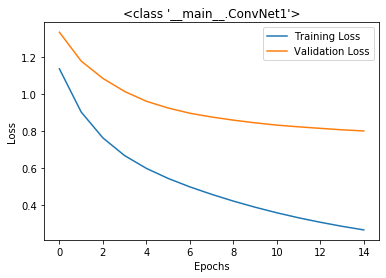

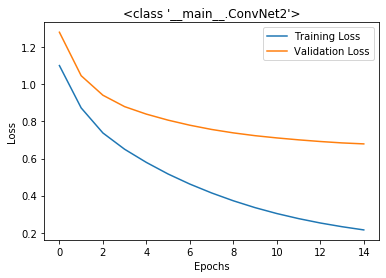

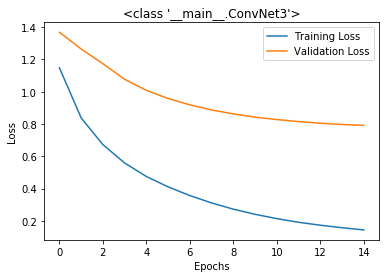

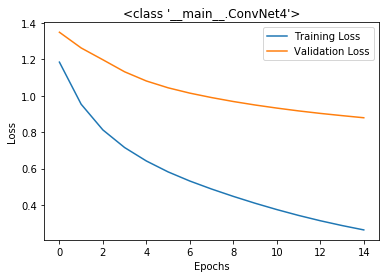

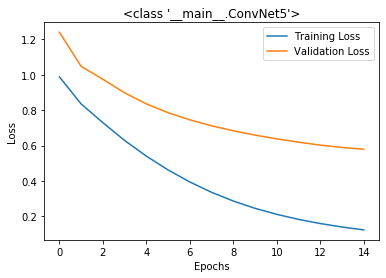

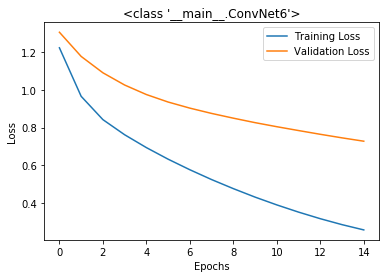

In [46]:
'''for model in models:
    plt.figure()
    plt.plot(model['training_losses'],label='Training Loss')
    plt.plot(model['validation_losses'],label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(type(model['model']))
    plt.legend()'''

In [48]:
'''for model in models:
    correct=0
    cnn.eval()
    with torch.no_grad():
        for  i,(X,y) in enumerate(test_loader): 
            m = model['model']
            y_h = m(X.cuda()).cpu()
            correct += (y==torch.argmax(F.softmax(y_h),dim=1)).sum()
    print(str(type(model['model']))+' Test Accuracy: ',round(float(correct/len(test_loader.sampler))*100,2))'''

/home/jatin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


<class '__main__.ConvNet1'> Test Accuracy:  68.68
<class '__main__.ConvNet2'> Test Accuracy:  69.43
<class '__main__.ConvNet3'> Test Accuracy:  68.3
<class '__main__.ConvNet4'> Test Accuracy:  71.7
<class '__main__.ConvNet5'> Test Accuracy:  73.21
<class '__main__.ConvNet6'> Test Accuracy:  71.7


In [49]:
'''
for m in models:
    f = open(str(type(m['model']))+'.pkl','wb')
    pickle.dump(m,f)
    f.close()
'''

In [110]:
'''models[4]['model']'''

ConvNet5(
  (convlayers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dila